In [1]:
# Imports
import os
import re
import json
import ast
import numpy as np
import pandas as pd
import torch
import warnings
warnings.filterwarnings('ignore')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from transformers import BartForConditionalGeneration, BartTokenizer
from transformers import BartForConditionalGeneration, BartTokenizer
from transformers import BertTokenizer, BertModel


<div class="alert alert-info">

## Data Description<a name="2"></a>

This project leverages a comprehensive dataset obtained from Kaggle, available at the following link: https://www.kaggle.com/datasets/yelp-dataset/yelp-dataset/data. The dataset encompasses several components, including information about businesses, user, reviews, and other related data. For this analysis, we utilized the business and reviews subsets.

After merging the two datasets, we obtained a dataset containing 6,990,280 rows and 21 columns. To focus on a specific subset, we filtered the data to include only restaurants, resulting in 3,773,971 observations. Further refinement was applied by filtering for users and businesses with significant interactions, specifically selecting those with at least 100 reviews for users and 500 reviews for businesses. The final dataset contains 51,618 observations, representing 1,408 unique users and 1,227 unique businesses.

</div>

In [5]:
yelp_business = pd.read_json("data/yelp/yelp_academic_dataset_business.json", lines=True)
yelp_reviews = pd.read_json("data/yelp/yelp_academic_dataset_review.json", lines = True)


In [6]:
yelp_business.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


In [7]:
yelp_reviews.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15


In [8]:
yelp_merged_df = pd.merge(yelp_business, yelp_reviews, on='business_id')
yelp_merged_df.rename(columns={'stars_y': 'stars'}, inplace=True)
yelp_merged_df.drop(columns=['stars_x'], inplace=True)
yelp_merged_df.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,review_count,is_open,...,categories,hours,review_id,user_id,stars,useful,funny,cool,text,date
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,7,0,...,"Doctors, Traditional Chinese Medicine, Naturop...",None,9vwYDBVI3ymdqcyJ5WW2Tg,e0imecnX_9MtLnS2rUZM-A,5,3,2,1,I've had acupuncture treatments with Abby over...,2012-05-02 18:07:38
1,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,7,0,...,"Doctors, Traditional Chinese Medicine, Naturop...",None,OXgg1LdxHDv3CBU5-xi2lA,_Q0fdLVoTnlNkEypUvNkHA,5,1,0,0,Abby is an amazing practitioner. In a treatmen...,2013-03-01 06:11:05
2,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,7,0,...,"Doctors, Traditional Chinese Medicine, Naturop...",None,DG64cjud9cWB4fANskVxSw,ycUooVIDWPgXPf6niW-FWQ,4,2,0,0,I went to see Abby for some digestive issues. ...,2013-01-17 00:05:43
3,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,7,0,...,"Doctors, Traditional Chinese Medicine, Naturop...",None,hzvRRb40oPttxAdyr7kfow,CiwVvb7jWijWB5jkmatzKA,5,0,1,0,"Abby helped me with some longstanding issues, ...",2015-03-16 03:43:08
4,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,7,0,...,"Doctors, Traditional Chinese Medicine, Naturop...",None,xUkBPk-QfcW4i3MRU5TeXw,QkCbMKBktkrkOFJugHvY6w,5,0,0,0,"Recently, I referred a patient of mine with mu...",2013-03-05 18:45:07


In [9]:
yelp_merged_df.shape

(6990280, 21)

In [10]:
restaurants_df = yelp_merged_df[yelp_merged_df['categories'].str.contains('Restaurant', case=False, na=False)]
restaurants_df = restaurants_df.query('is_open == 1')
restaurants_df.shape

(3773971, 21)

In [11]:
restaurants_df.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,review_count,is_open,...,categories,hours,review_id,user_id,stars,useful,funny,cool,text,date
46,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,80,1,...,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...",BXQcBN0iAi1lAUxibGLFzA,6_SpY41LIHZuIaiDs5FMKA,4,0,0,1,This is nice little Chinese bakery in the hear...,2014-05-26 01:09:53
47,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,80,1,...,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...",uduvUCvi9w3T2bSGivCfXg,tCXElwhzekJEH6QJe3xs7Q,4,3,1,2,This is the bakery I usually go to in Chinatow...,2013-10-05 15:19:06
48,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,80,1,...,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...",a0vwPOqDXXZuJkbBW2356g,WqfKtI-aGMmvbA9pPUxNQQ,5,0,0,0,"A delightful find in Chinatown! Very clean, an...",2013-10-25 01:34:57
49,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,80,1,...,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...",MKNp_CdR2k2202-c8GN5Dw,3-1va0IQfK-9tUMzfHWfTA,5,5,0,5,I ordered a graduation cake for my niece and i...,2018-05-20 17:58:57
50,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,80,1,...,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...",D1GisLDPe84Rrk_R4X2brQ,EouCKoDfzaVG0klEgdDvCQ,4,2,1,1,HK-STYLE MILK TEA: FOUR STARS\n\nNot quite su...,2013-10-25 02:31:35


In [12]:
restaurants_df['user_id'].nunique()

1277330

In [13]:
restaurants_df['business_id'].nunique()

35004

In [14]:
# Selected a subset with customers and business with at least 100 and 500 reviews
# Step 1: Filter customers with at least 100 reviews
yelp_customer_review_counts = restaurants_df.groupby('user_id').size().reset_index(name='user_review_count')
yelp_customers_with_at_least_100_reviews = yelp_customer_review_counts[yelp_customer_review_counts['user_review_count'] >= 100] 
# Step 2: Filter products with at least 500 reviews
yelp_review_counts = restaurants_df.groupby('business_id').size().reset_index(name='business_review_count')
yelp_with_at_least_100_reviews = yelp_review_counts[yelp_review_counts['business_review_count'] >= 500]

# Step 3: Filter the original dataset to only include customers and products with at least 100 and 500 reviews
yelp_filtered_data = restaurants_df[
    (restaurants_df['user_id'].isin(yelp_customers_with_at_least_100_reviews['user_id'])) & # This filter may need correction. A user might have contributed at least 100 reviews overall, but not necessarily to businesses meeting the >= 500 reviews condition.
    (restaurants_df['business_id'].isin(yelp_with_at_least_100_reviews['business_id'])) # Is this the expected behavior?
]
yelp_filtered_data.shape

(51618, 21)

In [15]:
yelp_filtered_data['user_id'].nunique()

1408

In [16]:
yelp_filtered_data['business_id'].nunique()

1227

In [17]:
user_key = "user_id"
item_key = "business_id"

In [18]:
avg_nratings_per_user = yelp_filtered_data.groupby(user_key).size().mean()
avg_nratings_per_movie = yelp_filtered_data.groupby(item_key).size().mean()
print(f"Average number of ratings per customer : {avg_nratings_per_user:.2f}")
print(f"Average number of ratings per product: {avg_nratings_per_movie:.2f}")

Average number of ratings per customer : 36.66
Average number of ratings per product: 42.07


In [19]:
yelp_filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51618 entries, 4493 to 6989787
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   business_id   51618 non-null  object        
 1   name          51618 non-null  object        
 2   address       51618 non-null  object        
 3   city          51618 non-null  object        
 4   state         51618 non-null  object        
 5   postal_code   51618 non-null  object        
 6   latitude      51618 non-null  float64       
 7   longitude     51618 non-null  float64       
 8   review_count  51618 non-null  int64         
 9   is_open       51618 non-null  int64         
 10  attributes    51618 non-null  object        
 11  categories    51618 non-null  object        
 12  hours         51536 non-null  object        
 13  review_id     51618 non-null  object        
 14  user_id       51618 non-null  object        
 15  stars         51618 non-null  int64 

In [20]:
yelp_filtered_data.isnull().sum()

business_id      0
name             0
address          0
city             0
state            0
postal_code      0
latitude         0
longitude        0
review_count     0
is_open          0
attributes       0
categories       0
hours           82
review_id        0
user_id          0
stars            0
useful           0
funny            0
cool             0
text             0
date             0
dtype: int64

In [21]:
yelp_filtered_data = yelp_filtered_data.dropna()

In [22]:
yelp_filtered_data.isnull().sum()

business_id     0
name            0
address         0
city            0
state           0
postal_code     0
latitude        0
longitude       0
review_count    0
is_open         0
attributes      0
categories      0
hours           0
review_id       0
user_id         0
stars           0
useful          0
funny           0
cool            0
text            0
date            0
dtype: int64

In [23]:
yelp_filtered_data.to_csv('data/yelp_reviews_subset.csv', index=False)

### Continue on

In [18]:
yelp_df = pd.read_csv('data/yelp_reviews_subset.csv')
yelp_df.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,review_count,is_open,...,categories,hours,review_id,user_id,stars,useful,funny,cool,text,date
0,oaboaRBUgGjbo2kfUIKDLQ,Mike's Ice Cream,129 2nd Ave N,Nashville,TN,37201,36.162649,-86.775973,593,1,...,"Ice Cream & Frozen Yogurt, Coffee & Tea, Resta...","{'Monday': '8:0-23:0', 'Tuesday': '8:0-23:0', ...",ljQTQY59Rjat2CQd02nYbQ,2iS1vg5TYpV_iEiNC8osTg,2,2,1,1,I ducked in here after walking the strip on a ...,2012-09-17 13:59:20
1,oaboaRBUgGjbo2kfUIKDLQ,Mike's Ice Cream,129 2nd Ave N,Nashville,TN,37201,36.162649,-86.775973,593,1,...,"Ice Cream & Frozen Yogurt, Coffee & Tea, Resta...","{'Monday': '8:0-23:0', 'Tuesday': '8:0-23:0', ...",smLabVSu-w9VFHA7gNLW6A,ZcNLb0XgmVOPcYvElhz3WA,4,0,0,0,"For a long time, I wondered how long downtown ...",2009-08-13 02:33:39
2,oaboaRBUgGjbo2kfUIKDLQ,Mike's Ice Cream,129 2nd Ave N,Nashville,TN,37201,36.162649,-86.775973,593,1,...,"Ice Cream & Frozen Yogurt, Coffee & Tea, Resta...","{'Monday': '8:0-23:0', 'Tuesday': '8:0-23:0', ...",rPZcnwOlfk6IOGXRyRrYCA,TylOr9YYTV3znqIvH7kdmQ,4,1,0,0,"Ice cream in the dead of winter? Yes, it was a...",2010-01-21 04:08:53
3,oaboaRBUgGjbo2kfUIKDLQ,Mike's Ice Cream,129 2nd Ave N,Nashville,TN,37201,36.162649,-86.775973,593,1,...,"Ice Cream & Frozen Yogurt, Coffee & Tea, Resta...","{'Monday': '8:0-23:0', 'Tuesday': '8:0-23:0', ...",5ViCByByt6xSFyYvQAwdcw,zfD3xhVNkGJs-AOOSslqtQ,5,0,0,0,Quite possibly the best ice cream I have ever ...,2012-06-17 18:06:28
4,oaboaRBUgGjbo2kfUIKDLQ,Mike's Ice Cream,129 2nd Ave N,Nashville,TN,37201,36.162649,-86.775973,593,1,...,"Ice Cream & Frozen Yogurt, Coffee & Tea, Resta...","{'Monday': '8:0-23:0', 'Tuesday': '8:0-23:0', ...",Yx5D1TZWmbjuVerYi6T9eA,KGmDAZI48MtoS_SnSkM0ag,3,0,0,0,This is a great place if you're downtown and w...,2009-01-29 14:18:14


In [22]:
yelp_df.attributes[112]

'{\'BusinessAcceptsCreditCards\': \'True\', \'RestaurantsReservations\': \'True\', \'HasTV\': \'False\', \'GoodForMeal\': "{\'dessert\': True, \'latenight\': None, \'lunch\': True, \'dinner\': True, \'brunch\': True, \'breakfast\': None}", \'RestaurantsGoodForGroups\': \'True\', \'BusinessParking\': "{\'garage\': False, \'street\': True, \'validated\': False, \'lot\': False, \'valet\': False}", \'RestaurantsAttire\': "u\'casual\'", \'NoiseLevel\': "u\'average\'", \'Ambience\': "{\'touristy\': False, \'hipster\': False, \'romantic\': True, \'divey\': False, \'intimate\': True, \'trendy\': True, \'upscale\': False, \'classy\': True, \'casual\': False}", \'Caters\': \'False\', \'DogsAllowed\': \'False\', \'RestaurantsTableService\': \'True\', \'Alcohol\': "u\'full_bar\'", \'BikeParking\': \'True\', \'HappyHour\': \'True\', \'RestaurantsTakeOut\': \'True\', \'WiFi\': "\'no\'", \'GoodForKids\': \'False\', \'RestaurantsDelivery\': \'True\', \'OutdoorSeating\': \'True\', \'RestaurantsPriceRan

In [24]:
# Apply the function to each row and collect the results
flattened = yelp_df['attributes'].apply(flatten_attributes)

# Convert the list of dictionaries into a DataFrame
flattened_yelp_df = pd.DataFrame(flattened.tolist())

# Merge the flattened attributes back into the original DataFrame
yelp_df = pd.concat([yelp_df, flattened_yelp_df], axis=1)

yelp_df.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,review_count,is_open,...,Smoking,BYOB,RestaurantsTableService,WheelchairAccessible,GoodForDancing,Corkage,RestaurantsCounterService,Open24Hours,AgesAllowed,DietaryRestrictions
0,oaboaRBUgGjbo2kfUIKDLQ,Mike's Ice Cream,129 2nd Ave N,Nashville,TN,37201,36.162649,-86.775973,593,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,oaboaRBUgGjbo2kfUIKDLQ,Mike's Ice Cream,129 2nd Ave N,Nashville,TN,37201,36.162649,-86.775973,593,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,oaboaRBUgGjbo2kfUIKDLQ,Mike's Ice Cream,129 2nd Ave N,Nashville,TN,37201,36.162649,-86.775973,593,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,oaboaRBUgGjbo2kfUIKDLQ,Mike's Ice Cream,129 2nd Ave N,Nashville,TN,37201,36.162649,-86.775973,593,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,oaboaRBUgGjbo2kfUIKDLQ,Mike's Ice Cream,129 2nd Ave N,Nashville,TN,37201,36.162649,-86.775973,593,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
check = yelp_df.iloc[:, 21:]
check.head()

,RestaurantsGoodForGroups,GoodForKids,BusinessParking,Alcohol,BusinessAcceptsCreditCards,NoiseLevel,Caters,Ambience,HasTV,RestaurantsReservations,...,Smoking,BYOB,RestaurantsTableService,WheelchairAccessible,GoodForDancing,Corkage,RestaurantsCounterService,Open24Hours,AgesAllowed,DietaryRestrictions
0,True,True,"{'garage': False, 'street': True, 'validated':...",u'none',True,u'average',False,"{'romantic': False, 'intimate': False, 'touris...",False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,True,True,"{'garage': False, 'street': True, 'validated':...",u'none',True,u'average',False,"{'romantic': False, 'intimate': False, 'touris...",False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,True,True,"{'garage': False, 'street': True, 'validated':...",u'none',True,u'average',False,"{'romantic': False, 'intimate': False, 'touris...",False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,True,True,"{'garage': False, 'street': True, 'validated':...",u'none',True,u'average',False,"{'romantic': False, 'intimate': False, 'touris...",False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,True,True,"{'garage': False, 'street': True, 'validated':...",u'none',True,u'average',False,"{'romantic': False, 'intimate': False, 'touris...",False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [241]:
# Group by user_id and count reviews
user_review_counts = yelp_df.groupby('user_id').size().reset_index(name='review_count')

# Find users with fewer than 100 reviews
users_below_100 = user_review_counts[user_review_counts['review_count'] < 100]
print(users_below_100)


                     user_id  review_count
0     -3s52C4zL_DHRK0ULG6qtg            34
1     -7XrSrJfHndHc_taEXurTw            27
2     -7qUbOVWJp2NT3f_TNuIBA            29
3     -B-QEUESGWHPE_889WJaeg            63
4     -CzwjrantVGMmZB8Qj_7-Q            35
...                      ...           ...
1403  zkQi7B9b-yFbF8k2XSnDHQ            39
1404  zsXoPyTcU8ThZGbtAB-Vug            42
1405  zu-e06_BM_TdkAZEKMrIww            56
1406  zv7tpu7xeaNyAeFG03d2CA            15
1407  zyvxtbh5eJ86bVgk52Yflg            33

[1379 rows x 2 columns]


In [242]:
yelp_df.shape

(51536, 21)

In [243]:
yelp_df['stars'].unique()

array([2, 4, 5, 3, 1])

In [244]:
# Reading the data
colab_data = yelp_df[['user_id', 'business_id', 'stars']].reset_index(drop=True)
colab_data.head()

,user_id,business_id,stars
0,2iS1vg5TYpV_iEiNC8osTg,oaboaRBUgGjbo2kfUIKDLQ,2
1,ZcNLb0XgmVOPcYvElhz3WA,oaboaRBUgGjbo2kfUIKDLQ,4
2,TylOr9YYTV3znqIvH7kdmQ,oaboaRBUgGjbo2kfUIKDLQ,4
3,zfD3xhVNkGJs-AOOSslqtQ,oaboaRBUgGjbo2kfUIKDLQ,5
4,KGmDAZI48MtoS_SnSkM0ag,oaboaRBUgGjbo2kfUIKDLQ,3


#### Normalizing the stars column

Normalizing to adjust the ratings so that they are relative to each user or item, rather than being treated as absolute values. 

This process helps to account for different rating behaviors among users or differing popularity across items.

**User Bias:** Some users might generally rate items higher or lower than others. For instance, one user might rate most restaurants as 5 stars while another user might be more conservative and give an average of 3 stars. Normalization helps reduce this bias.

**Improved Similarity Calculations:** When calculating similarities between users or items, normalization can improve the accuracy of those measures by removing biases.


In [140]:
# Group by user_id and calculate the mean rating for each user
user_mean = colab_data.groupby('user_id')['stars'].transform('mean')

# Subtract the mean rating for each user from their individual ratings
colab_data['normalized_stars'] = colab_data['stars'] - user_mean
colab_data.head()

,user_id,business_id,stars,normalized_stars
0,2iS1vg5TYpV_iEiNC8osTg,oaboaRBUgGjbo2kfUIKDLQ,2,-1.771429
1,ZcNLb0XgmVOPcYvElhz3WA,oaboaRBUgGjbo2kfUIKDLQ,4,0.769231
2,TylOr9YYTV3znqIvH7kdmQ,oaboaRBUgGjbo2kfUIKDLQ,4,0.509434
3,zfD3xhVNkGJs-AOOSslqtQ,oaboaRBUgGjbo2kfUIKDLQ,5,1.333333
4,KGmDAZI48MtoS_SnSkM0ag,oaboaRBUgGjbo2kfUIKDLQ,3,-0.800000


In [141]:
non_nan_ratings_percentage = (len(colab_data) / (N * M) * 100) 
print(f"Non-nan ratings percentage: {np.round(non_nan_ratings_percentage,3)}")

Non-nan ratings percentage: 2.99


In [142]:
avg_nratings_per_user = colab_data.groupby(user_key).size().mean()
avg_nratings_per_movie = colab_data.groupby(item_key).size().mean()
print(f"Average number of ratings per customer : {avg_nratings_per_user:.2f}")
print(f"Average number of ratings per product: {avg_nratings_per_movie:.2f}")

Average number of ratings per customer : 36.60
Average number of ratings per product: 42.10


In [143]:
colab_data.columns

Index(['user_id', 'business_id', 'stars', 'normalized_stars'], dtype='object')

#### Feature Engineering

#### 1- Business Popularity

Business popularity can be defined as the number of reviews it has received. I will create a business_popularity feature that we can merge into the dataFrame.


In [144]:
# Calculate business popularity: number of reviews for each business
business_popularity_data = colab_data.groupby('business_id')['user_id'].count().reset_index()
business_popularity_data.columns = ['business_id', 'popularity']

# Merge this popularity feature back to the main data frame
colab_data = colab_data.merge(business_popularity_data, on='business_id', how='left')

colab_data[['user_id', 'business_id', 'stars', 'normalized_stars', 'popularity']]

,user_id,business_id,stars,normalized_stars,popularity
0,2iS1vg5TYpV_iEiNC8osTg,oaboaRBUgGjbo2kfUIKDLQ,2,-1.771429,19
1,ZcNLb0XgmVOPcYvElhz3WA,oaboaRBUgGjbo2kfUIKDLQ,4,0.769231,19
2,TylOr9YYTV3znqIvH7kdmQ,oaboaRBUgGjbo2kfUIKDLQ,4,0.509434,19
3,zfD3xhVNkGJs-AOOSslqtQ,oaboaRBUgGjbo2kfUIKDLQ,5,1.333333,19
4,KGmDAZI48MtoS_SnSkM0ag,oaboaRBUgGjbo2kfUIKDLQ,3,-0.800000,19
...,...,...,...,...,...
51531,StZTVDuFzahNvjl5qu6l7Q,w_4xUt-1AyY2ZwKtnjW0Xg,4,0.238095,9
51532,E5Qm5W2BsMFCTirHq4DEIQ,w_4xUt-1AyY2ZwKtnjW0Xg,1,-1.666667,9
51533,G9P3h7ZGdbdc_Zt6IKC2vQ,w_4xUt-1AyY2ZwKtnjW0Xg,2,-2.163934,9
51534,ERh66eWeg5pQkA-vWpmx0Q,w_4xUt-1AyY2ZwKtnjW0Xg,5,0.966667,9


#### 2- User Activity

User activity can be defined as the number of businesses reviewed by a user. I can calculate this and add it as a new feature.


In [145]:
# Calculate user activity: number of businesses reviewed by each user
user_activity_data = colab_data.groupby('user_id')['business_id'].count().reset_index()
user_activity_data.columns = ['user_id', 'activity_level']

# Merge the user activity feature into the data frame
colab_data = colab_data.merge(user_activity_data, on='user_id', how='left')

colab_data[['user_id', 'business_id', 'stars', 'normalized_stars', 'popularity', 'activity_level']]


,user_id,business_id,stars,normalized_stars,popularity,activity_level
0,2iS1vg5TYpV_iEiNC8osTg,oaboaRBUgGjbo2kfUIKDLQ,2,-1.771429,19,70
1,ZcNLb0XgmVOPcYvElhz3WA,oaboaRBUgGjbo2kfUIKDLQ,4,0.769231,19,13
2,TylOr9YYTV3znqIvH7kdmQ,oaboaRBUgGjbo2kfUIKDLQ,4,0.509434,19,53
3,zfD3xhVNkGJs-AOOSslqtQ,oaboaRBUgGjbo2kfUIKDLQ,5,1.333333,19,30
4,KGmDAZI48MtoS_SnSkM0ag,oaboaRBUgGjbo2kfUIKDLQ,3,-0.800000,19,15
...,...,...,...,...,...,...
51531,StZTVDuFzahNvjl5qu6l7Q,w_4xUt-1AyY2ZwKtnjW0Xg,4,0.238095,9,21
51532,E5Qm5W2BsMFCTirHq4DEIQ,w_4xUt-1AyY2ZwKtnjW0Xg,1,-1.666667,9,9
51533,G9P3h7ZGdbdc_Zt6IKC2vQ,w_4xUt-1AyY2ZwKtnjW0Xg,2,-2.163934,9,61
51534,ERh66eWeg5pQkA-vWpmx0Q,w_4xUt-1AyY2ZwKtnjW0Xg,5,0.966667,9,30


In [146]:
# Making a copy 
colab_data_1 = colab_data.copy()
colab_data_1 = colab_data_1.drop(['normalized_stars', 'popularity', 'activity_level'], axis=1)
colab_data_1.head()

,user_id,business_id,stars
0,2iS1vg5TYpV_iEiNC8osTg,oaboaRBUgGjbo2kfUIKDLQ,2
1,ZcNLb0XgmVOPcYvElhz3WA,oaboaRBUgGjbo2kfUIKDLQ,4
2,TylOr9YYTV3znqIvH7kdmQ,oaboaRBUgGjbo2kfUIKDLQ,4
3,zfD3xhVNkGJs-AOOSslqtQ,oaboaRBUgGjbo2kfUIKDLQ,5
4,KGmDAZI48MtoS_SnSkM0ag,oaboaRBUgGjbo2kfUIKDLQ,3


In [147]:
# Data Splitting
from sklearn.model_selection import train_test_split

X = colab_data_1.copy()
y = colab_data_1['user_id']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=123)

In [148]:
user_mapper = dict(zip(np.unique(colab_data_1[user_key]), list(range(N))))
item_mapper = dict(zip(np.unique(colab_data_1[item_key]), list(range(M))))
user_inverse_mapper = dict(zip(list(range(N)), np.unique(colab_data_1[user_key])))
item_inverse_mapper = dict(zip(list(range(M)), np.unique(colab_data_1[item_key])))

In [149]:
# Create utility matrix
def create_Y_from_ratings(data, N, M):
    Y = np.zeros((N, M))
    Y.fill(np.nan)
    for index, val in data.iterrows():
        n = user_mapper[val[user_key]]
        m = item_mapper[val[item_key]]
        Y[n, m] = val["stars"]

    return Y

train_mat = create_Y_from_ratings(X_train, N, M)
valid_mat = create_Y_from_ratings(X_valid, N, M)

In [150]:
train_mat

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan,  5.],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], shape=(1408, 1224))

In [151]:
# What's the number of non-nan elements in train_mat (nnn_train_mat)?
nnn_train_mat = np.sum(~np.isnan(train_mat)) 

# What's the number of non-nan elements in valid_mat (nnn_valid_mat)?
nnn_valid_mat = np.sum(~np.isnan(valid_mat)) 
print(f"Number of non-nan elements in train_mat: {nnn_train_mat}")
print(f"Number of non-nan elements in valid_mat: {nnn_valid_mat}")

Number of non-nan elements in train_mat: 37218
Number of non-nan elements in valid_mat: 10030


In [152]:
# Evaluation
def error(Y1, Y2):
    """
    Given two matrices of the same shape, 
    returns the root mean squared error (RMSE).
    """
    # Calculate RMSE
    rmse = np.sqrt(np.nanmean((Y1 - Y2) ** 2))

    # Calculate the range of Y1 (ignoring NaN values)
    range_Y2 = np.nanmax(Y2) - np.nanmin(Y2)

    # Calculate relative RMSE
    relative_rmse = rmse / range_Y2 if range_Y2 != 0 else np.nan

    return relative_rmse


def evaluate(pred_Y, train_mat, valid_mat, model_name="Global average"):
    """
    Given predicted utility matrix and train and validation utility matrices 
    print train and validation RMSEs.
    """
    print("%s train RMSE: %0.2f" % (model_name, error(pred_Y, train_mat)))
    print("%s valid RMSE: %0.2f" % (model_name, error(pred_Y, valid_mat)))

In [153]:
# Calculate global average rating baseline
avg = np.nanmean(train_mat)
pred_g = np.zeros(train_mat.shape) + avg
evaluate(pred_g, train_mat, valid_mat, model_name="Global average")

Global average train RMSE: 0.24
Global average valid RMSE: 0.24


In [154]:
# Calculate per-user average baseline
avg_n = np.nanmean(train_mat, axis=1)
avg_n[
    np.isnan(avg_n)
] = avg  
pred_n = np.tile(avg_n[:, None], (1, M))
evaluate(pred_n, train_mat, valid_mat, model_name="Per-user average")

Per-user average train RMSE: 0.22
Per-user average valid RMSE: 0.23


In [155]:
# Calculate per-restaurant average baseline
avg_m = np.nanmean(train_mat, axis=0)
avg_m[np.isnan(avg_m)] = avg
pred_m = np.tile(avg_m[None, :], (N, 1))
evaluate(pred_m, train_mat, valid_mat, model_name="Per-product average")

Per-product average train RMSE: 0.22
Per-product average valid RMSE: 0.23


In [156]:
# Calculate average of per-user and per-restaurant average baselines
pred_n_m = (pred_n + pred_m) * 0.5
evaluate(pred_n_m, train_mat, valid_mat, model_name="Per-user and product average")

Per-user and product average train RMSE: 0.21
Per-user and product average valid RMSE: 0.22


In [157]:
# K-nearest neighbours imputation
from sklearn.impute import KNNImputer

num_neighs = [10, 15, 18, 20, 40]
for n_neighbors in num_neighs:
    print("\nNumber of neighbours: ", n_neighbors)
    imputer = KNNImputer(n_neighbors=n_neighbors, keep_empty_features=True)
    pred_knn = imputer.fit_transform(train_mat)
    evaluate(pred_knn, train_mat, valid_mat)


Number of neighbours:  10
Global average train RMSE: 0.00
Global average valid RMSE: 0.24

Number of neighbours:  15
Global average train RMSE: 0.00
Global average valid RMSE: 0.24

Number of neighbours:  18
Global average train RMSE: 0.00
Global average valid RMSE: 0.24

Number of neighbours:  20
Global average train RMSE: 0.00
Global average valid RMSE: 0.24

Number of neighbours:  40
Global average train RMSE: 0.00
Global average valid RMSE: 0.24


In [158]:
# Collaborative filtering with TruncatedSVD()
from sklearn.decomposition import TruncatedSVD

def reconstruct_svd(Z, W, avg_n, avg_m):
    return Z @ W + 0.5 * avg_n[:, None] + 0.5 * avg_m[None]


train_mat_svd = train_mat - 0.5 * avg_n[:, None] - 0.5 * avg_m[None]
train_mat_svd = np.nan_to_num(train_mat_svd)

k_range = [10, 50, 100, 200, 500, 1000]
for k in k_range:
    print("\n")
    tsvd = TruncatedSVD(n_components=k)
    Z = tsvd.fit_transform(train_mat_svd)
    W = tsvd.components_
    X_hat = reconstruct_svd(Z, W, avg_n, avg_m)
    evaluate(X_hat, train_mat, valid_mat, model_name="TruncatedSVD (k = %d)" % k)



TruncatedSVD (k = 10) train RMSE: 0.20
TruncatedSVD (k = 10) valid RMSE: 0.22


TruncatedSVD (k = 50) train RMSE: 0.17
TruncatedSVD (k = 50) valid RMSE: 0.22


TruncatedSVD (k = 100) train RMSE: 0.15
TruncatedSVD (k = 100) valid RMSE: 0.22


TruncatedSVD (k = 200) train RMSE: 0.11
TruncatedSVD (k = 200) valid RMSE: 0.23


TruncatedSVD (k = 500) train RMSE: 0.04
TruncatedSVD (k = 500) valid RMSE: 0.23


TruncatedSVD (k = 1000) train RMSE: 0.00
TruncatedSVD (k = 1000) valid RMSE: 0.23


In [159]:
# Using surprise package
# from surprise import Reader


# reader = Reader()
# data = Dataset.load_from_df(coll_data, reader)  

# k = 10
# algo = SVD(n_factors=k, random_state=42)
# pd.DataFrame(cross_validate(algo, data, measures=["RMSE"], cv=5, verbose=True))


Lets now use the other features for creating the utility matrix.

#### normalized_stars

In [160]:
# Making a copy 
colab_data_2 = colab_data.copy()
colab_data_2 = colab_data_2.drop(['stars', 'popularity', 'activity_level'], axis=1)
colab_data_2.head()

,user_id,business_id,normalized_stars
0,2iS1vg5TYpV_iEiNC8osTg,oaboaRBUgGjbo2kfUIKDLQ,-1.771429
1,ZcNLb0XgmVOPcYvElhz3WA,oaboaRBUgGjbo2kfUIKDLQ,0.769231
2,TylOr9YYTV3znqIvH7kdmQ,oaboaRBUgGjbo2kfUIKDLQ,0.509434
3,zfD3xhVNkGJs-AOOSslqtQ,oaboaRBUgGjbo2kfUIKDLQ,1.333333
4,KGmDAZI48MtoS_SnSkM0ag,oaboaRBUgGjbo2kfUIKDLQ,-0.800000


In [161]:
# Data Splitting
from sklearn.model_selection import train_test_split

X = colab_data_2.copy()
y = colab_data_2['user_id']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=123)

In [162]:
user_mapper = dict(zip(np.unique(colab_data_2[user_key]), list(range(N))))
item_mapper = dict(zip(np.unique(colab_data_2[item_key]), list(range(M))))
user_inverse_mapper = dict(zip(list(range(N)), np.unique(colab_data_2[user_key])))
item_inverse_mapper = dict(zip(list(range(M)), np.unique(colab_data_2[item_key])))

In [163]:
# Create utility matrix
def create_Y_from_ratings(data, N, M):
    Y = np.zeros((N, M))
    Y.fill(np.nan)
    for index, val in data.iterrows():
        n = user_mapper[val[user_key]]
        m = item_mapper[val[item_key]]
        Y[n, m] = val["normalized_stars"]

    return Y

train_mat = create_Y_from_ratings(X_train, N, M)
valid_mat = create_Y_from_ratings(X_valid, N, M)

In [164]:
train_mat

array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
        0.55172414],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]], shape=(1408, 1224))

In [165]:
# Calculate global average rating baseline
avg = np.nanmean(train_mat)
pred_g = np.zeros(train_mat.shape) + avg
evaluate(pred_g, train_mat, valid_mat, model_name="Global average")

Global average train RMSE: 0.13
Global average valid RMSE: 0.15


In [166]:
# Calculate per-user average baseline
avg_n = np.nanmean(train_mat, axis=1)
avg_n[
    np.isnan(avg_n)
] = avg  
pred_n = np.tile(avg_n[:, None], (1, M))
evaluate(pred_n, train_mat, valid_mat, model_name="Per-user average")

Per-user average train RMSE: 0.13
Per-user average valid RMSE: 0.16


In [167]:
# Calculate per-restaurant average baseline
avg_m = np.nanmean(train_mat, axis=0)
avg_m[np.isnan(avg_m)] = avg
pred_m = np.tile(avg_m[None, :], (N, 1))
evaluate(pred_m, train_mat, valid_mat, model_name="Per-product average")

Per-product average train RMSE: 0.12
Per-product average valid RMSE: 0.14


In [168]:
# Calculate average of per-user and per-restaurant average baselines
pred_n_m = (pred_n + pred_m) * 0.5
evaluate(pred_n_m, train_mat, valid_mat, model_name="Per-user and product average")

Per-user and product average train RMSE: 0.13
Per-user and product average valid RMSE: 0.15


In [169]:
# K-nearest neighbours imputation
from sklearn.impute import KNNImputer

num_neighs = [10, 15, 18, 20, 40]
for n_neighbors in num_neighs:
    print("\nNumber of neighbours: ", n_neighbors)
    imputer = KNNImputer(n_neighbors=n_neighbors, keep_empty_features=True)
    pred_knn = imputer.fit_transform(train_mat)
    evaluate(pred_knn, train_mat, valid_mat)


Number of neighbours:  10
Global average train RMSE: 0.00
Global average valid RMSE: 0.16

Number of neighbours:  15
Global average train RMSE: 0.00
Global average valid RMSE: 0.15

Number of neighbours:  18
Global average train RMSE: 0.00
Global average valid RMSE: 0.15

Number of neighbours:  20
Global average train RMSE: 0.00
Global average valid RMSE: 0.15

Number of neighbours:  40
Global average train RMSE: 0.00
Global average valid RMSE: 0.15


So far so good!

Now, lets incorporate the `popularity` and `activity_level` as weights for the original matrix that is created from `normalized_stars` and not `stars`.

##### Popularity

In [170]:
# Making a copy 
colab_data_pop = colab_data.copy()
colab_data_pop = colab_data_pop.drop(['stars', 'normalized_stars','activity_level'], axis=1)
colab_data_pop.head()

,user_id,business_id,popularity
0,2iS1vg5TYpV_iEiNC8osTg,oaboaRBUgGjbo2kfUIKDLQ,19
1,ZcNLb0XgmVOPcYvElhz3WA,oaboaRBUgGjbo2kfUIKDLQ,19
2,TylOr9YYTV3znqIvH7kdmQ,oaboaRBUgGjbo2kfUIKDLQ,19
3,zfD3xhVNkGJs-AOOSslqtQ,oaboaRBUgGjbo2kfUIKDLQ,19
4,KGmDAZI48MtoS_SnSkM0ag,oaboaRBUgGjbo2kfUIKDLQ,19


In [171]:
# Data Splitting
from sklearn.model_selection import train_test_split

X_pop = colab_data_pop.copy()
y_pop = colab_data_pop['user_id']
X_train_pop, X_valid_pop, y_train_pop, y_valid_pop = train_test_split(X_pop, y_pop, test_size=0.2, random_state=123)

In [172]:
user_mapper_pop = dict(zip(np.unique(colab_data_pop[user_key]), list(range(N))))
item_mapper_pop = dict(zip(np.unique(colab_data_pop[item_key]), list(range(M))))
user_inverse_mapper_pop = dict(zip(list(range(N)), np.unique(colab_data_pop[user_key])))
item_inverse_mapper_pop = dict(zip(list(range(M)), np.unique(colab_data_pop[item_key])))

In [173]:
# Create utility matrix for Popularity
def create_Y_from_ratings(data, N, M):
    Y = np.zeros((N, M))
    Y.fill(np.nan)
    for index, val in data.iterrows():
        n = user_mapper[val[user_key]]
        m = item_mapper[val[item_key]]
        Y[n, m] = val["popularity"]

    return Y

train_mat_pop = create_Y_from_ratings(X_train_pop, N, M)
valid_mat_pop = create_Y_from_ratings(X_valid_pop, N, M)

In [174]:
train_mat_pop

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, 34.],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], shape=(1408, 1224))

In [175]:
# Normalize modifier matrice popularity
train_mat_pop_normalized = train_mat_pop / np.nanmax(train_mat_pop)
valid_mat_pop_normalized = valid_mat_pop / np.nanmax(valid_mat_pop)

##### Activity_level

In [176]:
# Making a copy 
colab_data_al = colab_data.copy()
colab_data_al = colab_data_al.drop(['stars', 'normalized_stars','popularity'], axis=1)
colab_data_al.head()

,user_id,business_id,activity_level
0,2iS1vg5TYpV_iEiNC8osTg,oaboaRBUgGjbo2kfUIKDLQ,70
1,ZcNLb0XgmVOPcYvElhz3WA,oaboaRBUgGjbo2kfUIKDLQ,13
2,TylOr9YYTV3znqIvH7kdmQ,oaboaRBUgGjbo2kfUIKDLQ,53
3,zfD3xhVNkGJs-AOOSslqtQ,oaboaRBUgGjbo2kfUIKDLQ,30
4,KGmDAZI48MtoS_SnSkM0ag,oaboaRBUgGjbo2kfUIKDLQ,15


In [177]:
# Data Splitting
from sklearn.model_selection import train_test_split

X_al = colab_data_al.copy()
y_al = colab_data_al['user_id']
X_train_al, X_valid_al, y_train_al, y_valid_al = train_test_split(X_al, y_al, test_size=0.2, random_state=123)

In [178]:
user_mapper_al = dict(zip(np.unique(colab_data_al[user_key]), list(range(N))))
item_mapper_al = dict(zip(np.unique(colab_data_al[item_key]), list(range(M))))
user_inverse_mapper_al = dict(zip(list(range(N)), np.unique(colab_data_al[user_key])))
item_inverse_mapper_al = dict(zip(list(range(M)), np.unique(colab_data_al[item_key])))

In [179]:
# Create utility matrix for Activity_level
def create_Y_from_ratings(data, N, M):
    Y = np.zeros((N, M))
    Y.fill(np.nan)
    for index, val in data.iterrows():
        n = user_mapper[val[user_key]]
        m = item_mapper[val[item_key]]
        Y[n, m] = val["activity_level"]

    return Y

train_mat_al = create_Y_from_ratings(X_train_al, N, M)
valid_mat_al = create_Y_from_ratings(X_valid_al, N, M)

In [180]:
train_mat_al

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, 29.],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], shape=(1408, 1224))

In [181]:
# Normalize modifier matrice acticvity_level
train_mat_al_normalized = train_mat_al / np.nanmax(train_mat_al)
valid_mat_al_normalized = valid_mat_al / np.nanmax(valid_mat_al)

##### Applying the weight modifiers to the main matrix

In [182]:
# Apply modifiers to the main matrix
train_mat_final = train_mat * train_mat_pop_normalized
valid_mat_final = valid_mat * valid_mat_pop_normalized


In [183]:
train_mat_final

array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
        0.08411938],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]], shape=(1408, 1224))

In [184]:
# Calculate global average rating baseline
avg = np.nanmean(train_mat_final)
pred_g = np.zeros(train_mat_final.shape) + avg
evaluate(pred_g, train_mat_final, valid_mat_final, model_name="Global average")

Global average train RMSE: 0.06
Global average valid RMSE: 0.06


In [185]:
# Calculate per-user average baseline
avg_n = np.nanmean(train_mat_final, axis=1)
avg_n[
    np.isnan(avg_n)
] = avg  
pred_n = np.tile(avg_n[:, None], (1, M))
evaluate(pred_n, train_mat_final, valid_mat_final, model_name="Per-user average")

Per-user average train RMSE: 0.06
Per-user average valid RMSE: 0.06


In [186]:
# Calculate per-restaurant average baseline
avg_m = np.nanmean(train_mat_final, axis=0)
avg_m[np.isnan(avg_m)] = avg
pred_m = np.tile(avg_m[None, :], (N, 1))
evaluate(pred_m, train_mat_final, valid_mat_final, model_name="Per-product average")

Per-product average train RMSE: 0.05
Per-product average valid RMSE: 0.06


In [187]:
# Calculate average of per-user and per-restaurant average baselines
pred_n_m = (pred_n + pred_m) * 0.5
evaluate(pred_n_m, train_mat_final, valid_mat_final, model_name="Per-user and product average")

Per-user and product average train RMSE: 0.05
Per-user and product average valid RMSE: 0.06


In [188]:
# K-nearest neighbours imputation
from sklearn.impute import KNNImputer

num_neighs = [10, 15, 18, 20, 40]
for n_neighbors in num_neighs:
    print("\nNumber of neighbours: ", n_neighbors)
    imputer = KNNImputer(n_neighbors=n_neighbors, keep_empty_features=True)
    pred_knn = imputer.fit_transform(train_mat_final)
    evaluate(pred_knn, train_mat_final, valid_mat_final)


Number of neighbours:  10
Global average train RMSE: 0.00
Global average valid RMSE: 0.06

Number of neighbours:  15
Global average train RMSE: 0.00
Global average valid RMSE: 0.06

Number of neighbours:  18
Global average train RMSE: 0.00
Global average valid RMSE: 0.06

Number of neighbours:  20
Global average train RMSE: 0.00
Global average valid RMSE: 0.06

Number of neighbours:  40
Global average train RMSE: 0.00
Global average valid RMSE: 0.06


In [189]:
# Collaborative filtering with TruncatedSVD()
from sklearn.decomposition import TruncatedSVD

def reconstruct_svd(Z, W, avg_n, avg_m):
    return Z @ W + 0.5 * avg_n[:, None] + 0.5 * avg_m[None]


train_mat_final_svd = train_mat_final - 0.5 * avg_n[:, None] - 0.5 * avg_m[None]
train_mat_final_svd = np.nan_to_num(train_mat_final_svd)

k_range = [10, 50, 100, 200, 500, 1000]
for k in k_range:
    print("\n")
    tsvd = TruncatedSVD(n_components=k)
    Z = tsvd.fit_transform(train_mat_final_svd)
    W = tsvd.components_
    X_hat = reconstruct_svd(Z, W, avg_n, avg_m)
    evaluate(X_hat, train_mat_final, valid_mat_final, model_name="TruncatedSVD (k = %d)" % k)



TruncatedSVD (k = 10) train RMSE: 0.05
TruncatedSVD (k = 10) valid RMSE: 0.06


TruncatedSVD (k = 50) train RMSE: 0.03
TruncatedSVD (k = 50) valid RMSE: 0.06


TruncatedSVD (k = 100) train RMSE: 0.03
TruncatedSVD (k = 100) valid RMSE: 0.06


TruncatedSVD (k = 200) train RMSE: 0.02
TruncatedSVD (k = 200) valid RMSE: 0.06


TruncatedSVD (k = 500) train RMSE: 0.01
TruncatedSVD (k = 500) valid RMSE: 0.06


TruncatedSVD (k = 1000) train RMSE: 0.00
TruncatedSVD (k = 1000) valid RMSE: 0.06


##### Applying the weight modifiers to the main matrix

In [190]:
# Apply modifiers to the main matrix
train_mat_final = train_mat * train_mat_al_normalized
valid_mat_final = valid_mat * valid_mat_al_normalized

In [191]:
train_mat_final.shape

(1408, 1224)

In [192]:
# Calculate global average rating baseline
avg = np.nanmean(train_mat_final)
pred_g = np.zeros(train_mat_final.shape) + avg
evaluate(pred_g, train_mat_final, valid_mat_final, model_name="Global average")

Global average train RMSE: 0.06
Global average valid RMSE: 0.07


In [193]:
# Calculate per-user average baseline
avg_n = np.nanmean(train_mat_final, axis=1)
avg_n[
    np.isnan(avg_n)
] = avg  
pred_n = np.tile(avg_n[:, None], (1, M))
evaluate(pred_n, train_mat_final, valid_mat_final, model_name="Per-user average")

Per-user average train RMSE: 0.06
Per-user average valid RMSE: 0.07


In [194]:
# Calculate average of per-user and per-restaurant average baselines
pred_n_m = (pred_n + pred_m) * 0.5
evaluate(pred_n_m, train_mat_final, valid_mat_final, model_name="Per-user and product average")

Per-user and product average train RMSE: 0.06
Per-user and product average valid RMSE: 0.06


In [195]:
# K-nearest neighbours imputation
from sklearn.impute import KNNImputer

num_neighs = [10, 15, 18, 20, 40]
for n_neighbors in num_neighs:
    print("\nNumber of neighbours: ", n_neighbors)
    imputer = KNNImputer(n_neighbors=n_neighbors, keep_empty_features=True)
    pred_knn = imputer.fit_transform(train_mat_final)
    evaluate(pred_knn, train_mat_final, valid_mat_final)


Number of neighbours:  10
Global average train RMSE: 0.00
Global average valid RMSE: 0.07

Number of neighbours:  15
Global average train RMSE: 0.00
Global average valid RMSE: 0.07

Number of neighbours:  18
Global average train RMSE: 0.00
Global average valid RMSE: 0.07

Number of neighbours:  20
Global average train RMSE: 0.00
Global average valid RMSE: 0.07

Number of neighbours:  40
Global average train RMSE: 0.00
Global average valid RMSE: 0.07


In [196]:
# Collaborative filtering with TruncatedSVD()
from sklearn.decomposition import TruncatedSVD

def reconstruct_svd(Z, W, avg_n, avg_m):
    return Z @ W + 0.5 * avg_n[:, None] + 0.5 * avg_m[None]


train_mat_final_svd = train_mat_final - 0.5 * avg_n[:, None] - 0.5 * avg_m[None]
train_mat_final_svd = np.nan_to_num(train_mat_final_svd)

k_range = [10, 50, 100, 200, 500, 1000]
for k in k_range:
    print("\n")
    tsvd = TruncatedSVD(n_components=k)
    Z = tsvd.fit_transform(train_mat_final_svd)
    W = tsvd.components_
    X_hat = reconstruct_svd(Z, W, avg_n, avg_m)
    evaluate(X_hat, train_mat_final, valid_mat_final, model_name="TruncatedSVD (k = %d)" % k)



TruncatedSVD (k = 10) train RMSE: 0.05
TruncatedSVD (k = 10) valid RMSE: 0.07


TruncatedSVD (k = 50) train RMSE: 0.04
TruncatedSVD (k = 50) valid RMSE: 0.07


TruncatedSVD (k = 100) train RMSE: 0.03
TruncatedSVD (k = 100) valid RMSE: 0.07


TruncatedSVD (k = 200) train RMSE: 0.02
TruncatedSVD (k = 200) valid RMSE: 0.07


TruncatedSVD (k = 500) train RMSE: 0.01
TruncatedSVD (k = 500) valid RMSE: 0.07


TruncatedSVD (k = 1000) train RMSE: 0.00
TruncatedSVD (k = 1000) valid RMSE: 0.07


This seems to give pretty much the same results as the popularity multiplier.

**So we can conclude the these feature engineering does improve the accuracy of the baselines. But to confirm this, it is best to first split the data to train/test and then do the feature engineering for each split separately.**

### The same approach but with splitting the data first

In [245]:
# Reading the data
colab_data = yelp_df[['user_id', 'business_id', 'stars']].reset_index(drop=True)


# Data Splitting
from sklearn.model_selection import train_test_split

# train = colab_data.copy()
# y = colab_data['user_id'] # What is the idea behind X & y splits while only the X is used.
colab_train, colab_valid = train_test_split(colab_data, test_size=0.2, random_state=123)

# Group by user_id and calculate the mean rating for each user
user_mean = colab_train.groupby('user_id')['stars'].transform('mean')

# Normalizing the stars, train set
# Subtract the mean rating for each user from their individual ratings
colab_train['normalized_stars'] = colab_train['stars'] - user_mean

# Group by user_id and calculate the mean rating for each user
user_mean = colab_valid.groupby('user_id')['stars'].transform('mean')

# Normalizing the stars, valid set
# Subtract the mean rating for each user from their individual ratings
colab_valid['normalized_stars'] = colab_valid['stars'] - user_mean

# Popularity column
# Calculate business popularity: number of reviews for each business
business_popularity_train_data = colab_train.groupby('business_id')['user_id'].count().reset_index()
business_popularity_train_data.columns = ['business_id', 'popularity']

# Merge this popularity feature back to the main data frame
colab_train = colab_train.merge(business_popularity_train_data, on='business_id', how='left')

colab_train[['user_id', 'business_id', 'stars', 'normalized_stars', 'popularity']]

# Calculate business popularity: number of reviews for each business
business_popularity_valid_data = colab_valid.groupby('business_id')['user_id'].count().reset_index()
business_popularity_valid_data.columns = ['business_id', 'popularity']

# Merge this popularity feature back to the main data frame
colab_valid = colab_valid.merge(business_popularity_valid_data, on='business_id', how='left')

colab_valid[['user_id', 'business_id', 'stars', 'normalized_stars', 'popularity']]

# User activity_level column, train set
# Calculate user activity: number of businesses reviewed by each user
user_activity_train_data = colab_train.groupby('user_id')['business_id'].count().reset_index()
user_activity_train_data.columns = ['user_id', 'activity_level']

# Merge the user activity feature into the data frame
colab_train = colab_train.merge(user_activity_train_data, on='user_id', how='left')

colab_train[['user_id', 'business_id', 'stars', 'normalized_stars', 'popularity', 'activity_level']]

# User activity_level column, valid set
# Calculate user activity: number of businesses reviewed by each user
user_activity_valid_data = colab_valid.groupby('user_id')['business_id'].count().reset_index()
user_activity_valid_data.columns = ['user_id', 'activity_level']

# Merge the user activity feature into the data frame
colab_valid = colab_valid.merge(user_activity_valid_data, on='user_id', how='left')

colab_valid[['user_id', 'business_id', 'stars', 'normalized_stars', 'popularity', 'activity_level']]

# Number of customers and products
user_key = "user_id"
item_key = "business_id"
N = len(np.unique(colab_data[user_key])) 
M = len(np.unique(colab_data[item_key]))
# print(f"Number of customers (N)  : {N}")
# print(f"Number of products (M) : {M}")

# Code for utility matrix
user_mapper = dict(zip(np.unique(colab_data[user_key]), list(range(N))))
item_mapper = dict(zip(np.unique(colab_data[item_key]), list(range(M))))
user_inverse_mapper = dict(zip(list(range(N)), np.unique(colab_data[user_key])))
item_inverse_mapper = dict(zip(list(range(M)), np.unique(colab_data[item_key])))

## stars

In [249]:
# Making a copy for the stars column
colab_train_s = colab_train.copy()
colab_valid_s = colab_valid.copy()
colab_train_s = colab_train_s.drop(['normalized_stars', 'popularity', 'activity_level'], axis=1)
colab_valid_s = colab_valid_s.drop(['normalized_stars', 'popularity', 'activity_level'], axis=1)

# Create utility matrix
def create_Y_from_ratings(data, N, M):
    Y = np.zeros((N, M))
    Y.fill(np.nan)
    for index, val in data.iterrows():
        n = user_mapper[val[user_key]]
        m = item_mapper[val[item_key]]
        Y[n, m] = val["stars"]

    return Y

# Creating the utility matrix
train_mat_s = create_Y_from_ratings(colab_train_s, N, M)
valid_mat_s = create_Y_from_ratings(colab_valid_s, N, M)

# Evaluation
def error(Y1, Y2):
    """
    Given two matrices of the same shape, 
    returns the root mean squared error (RMSE).
    """
    # Calculate RMSE
    rmse = np.sqrt(np.nanmean((Y1 - Y2) ** 2))

    # Calculate the range of Y1 (ignoring NaN values)
    range_Y2 = np.nanmax(Y2) - np.nanmin(Y2)

    # Calculate relative RMSE
    relative_rmse = rmse / range_Y2 if range_Y2 != 0 else np.nan

    return relative_rmse


def evaluate(pred_Y, train_mat_s, valid_mat_s, model_name="Global average"):
    """
    Given predicted utility matrix and train and validation utility matrices 
    print train and validation RMSEs.
    """
    print("%s train RMSE: %0.2f" % (model_name, error(pred_Y, train_mat_s)))
    print("%s valid RMSE: %0.2f" % (model_name, error(pred_Y, valid_mat_s)))



# Calculate global average rating baseline
avg = np.nanmean(train_mat_s)
pred_g = np.zeros(train_mat_s.shape) + avg
evaluate(pred_g, train_mat_s, valid_mat_s, model_name="Global average")

print("-" * 40)  # Prints a line of 40 dashes

# Calculate per-user average baseline
avg_n = np.nanmean(train_mat_s, axis=1)
avg_n[
    np.isnan(avg_n)
] = avg  
pred_n = np.tile(avg_n[:, None], (1, M))
evaluate(pred_n, train_mat_s, valid_mat_s, model_name="Per-user average")

print("-" * 40)  # Prints a line of 40 dashes


# Calculate per-restaurant average baseline
avg_m = np.nanmean(train_mat_s, axis=0)
avg_m[np.isnan(avg_m)] = avg
pred_m = np.tile(avg_m[None, :], (N, 1))
evaluate(pred_m, train_mat_s, valid_mat_s, model_name="Per-product average")

print("-" * 40)  # Prints a line of 40 dashes

# Calculate average of per-user and per-restaurant average baselines
pred_n_m = (pred_n + pred_m) * 0.5
evaluate(pred_n_m, train_mat_s, valid_mat_s, model_name="Per-user and product average")

print("-" * 40)  # Prints a line of 40 dashes

# K-nearest neighbours imputation
from sklearn.impute import KNNImputer

num_neighs = [10, 15, 18, 20, 40]
for n_neighbors in num_neighs:
    print("\nNumber of neighbours: ", n_neighbors)
    imputer = KNNImputer(n_neighbors=n_neighbors, keep_empty_features=True)
    pred_knn = imputer.fit_transform(train_mat_s)
    evaluate(pred_knn, train_mat_s, valid_mat_s)


print("-" * 40)  # Prints a line of 40 dashes


# Collaborative filtering with TruncatedSVD()
from sklearn.decomposition import TruncatedSVD

def reconstruct_svd(Z, W, avg_n, avg_m):
    return Z @ W + 0.5 * avg_n[:, None] + 0.5 * avg_m[None]


train_mat_svd = train_mat_s - 0.5 * avg_n[:, None] - 0.5 * avg_m[None]
train_mat_svd = np.nan_to_num(train_mat_svd)

k_range = [10, 50, 100, 200, 500, 1000]
for k in k_range:
    print("\n")
    tsvd = TruncatedSVD(n_components=k)
    Z = tsvd.fit_transform(train_mat_svd)
    W = tsvd.components_
    X_hat = reconstruct_svd(Z, W, avg_n, avg_m)
    evaluate(X_hat, train_mat_s, valid_mat_s, model_name="TruncatedSVD (k = %d)" % k)

Global average train RMSE: 0.24
Global average valid RMSE: 0.24
----------------------------------------
Per-user average train RMSE: 0.22
Per-user average valid RMSE: 0.23
----------------------------------------
Per-product average train RMSE: 0.22
Per-product average valid RMSE: 0.23
----------------------------------------
Per-user and product average train RMSE: 0.21
Per-user and product average valid RMSE: 0.22
----------------------------------------

Number of neighbours:  10
Global average train RMSE: 0.00
Global average valid RMSE: 0.24

Number of neighbours:  15
Global average train RMSE: 0.00
Global average valid RMSE: 0.24

Number of neighbours:  18
Global average train RMSE: 0.00
Global average valid RMSE: 0.24

Number of neighbours:  20
Global average train RMSE: 0.00
Global average valid RMSE: 0.24

Number of neighbours:  40
Global average train RMSE: 0.00
Global average valid RMSE: 0.24
----------------------------------------


TruncatedSVD (k = 10) train RMSE: 0.20
T

## normalized_stars

In [247]:
# Making a copy for the normalized_stars column
colab_train_ns = colab_train.copy()
colab_valid_ns = colab_valid.copy()
colab_train_ns = colab_train_ns.drop(['stars', 'popularity', 'activity_level'], axis=1)
colab_valid_ns = colab_valid_ns.drop(['stars', 'popularity', 'activity_level'], axis=1)

# Create utility matrix
def create_Y_from_ratings(data, N, M):
    Y = np.zeros((N, M))
    Y.fill(np.nan)
    for index, val in data.iterrows():
        n = user_mapper[val[user_key]]
        m = item_mapper[val[item_key]]
        Y[n, m] = val["normalized_stars"]

    return Y
    
# Creating the utility matrix
train_mat_ns = create_Y_from_ratings(colab_train_ns, N, M)
valid_mat_ns = create_Y_from_ratings(colab_valid_ns, N, M)

# Evaluation
def error(Y1, Y2):
    """
    Given two matrices of the same shape, 
    returns the root mean squared error (RMSE).
    """
    # Calculate RMSE
    rmse = np.sqrt(np.nanmean((Y1 - Y2) ** 2))

    # Calculate the range of Y1 (ignoring NaN values)
    range_Y2 = np.nanmax(Y2) - np.nanmin(Y2)

    # Calculate relative RMSE
    relative_rmse = rmse / range_Y2 if range_Y2 != 0 else np.nan

    return relative_rmse


def evaluate(pred_Y, train_mat_ns, valid_mat_ns, model_name="Global average"):
    """
    Given predicted utility matrix and train and validation utility matrices 
    print train and validation RMSEs.
    """
    print("%s train RMSE: %0.2f" % (model_name, error(pred_Y, train_mat_ns)))
    print("%s valid RMSE: %0.2f" % (model_name, error(pred_Y, valid_mat_ns)))


# Calculate global average rating baseline
avg = np.nanmean(train_mat_ns)
pred_g = np.zeros(train_mat_ns.shape) + avg
evaluate(pred_g, train_mat_ns, valid_mat_ns, model_name="Global average")

print("-" * 40)  # Prints a line of 40 dashes

# Calculate per-user average baseline
avg_n = np.nanmean(train_mat_ns, axis=1)
avg_n[
    np.isnan(avg_n)
] = avg  
pred_n = np.tile(avg_n[:, None], (1, M))
evaluate(pred_n, train_mat_ns, valid_mat_ns, model_name="Per-user average")

print("-" * 40)  # Prints a line of 40 dashes


# Calculate per-restaurant average baseline
avg_m = np.nanmean(train_mat_ns, axis=0)
avg_m[np.isnan(avg_m)] = avg
pred_m = np.tile(avg_m[None, :], (N, 1))
evaluate(pred_m, train_mat_ns, valid_mat_ns, model_name="Per-product average")

print("-" * 40)  # Prints a line of 40 dashes

# Calculate average of per-user and per-restaurant average baselines
pred_n_m = (pred_n + pred_m) * 0.5
evaluate(pred_n_m, train_mat_ns, valid_mat_ns, model_name="Per-user and product average")

print("-" * 40)  # Prints a line of 40 dashes

# K-nearest neighbours imputation
from sklearn.impute import KNNImputer

num_neighs = [10, 15, 18, 20, 40]
for n_neighbors in num_neighs:
    print("\nNumber of neighbours: ", n_neighbors)
    imputer = KNNImputer(n_neighbors=n_neighbors, keep_empty_features=True)
    pred_knn = imputer.fit_transform(train_mat_ns)
    evaluate(pred_knn, train_mat_ns, valid_mat_ns)


print("-" * 40)  # Prints a line of 40 dashes


# Collaborative filtering with TruncatedSVD()
from sklearn.decomposition import TruncatedSVD

def reconstruct_svd(Z, W, avg_n, avg_m):
    return Z @ W + 0.5 * avg_n[:, None] + 0.5 * avg_m[None]


train_mat_svd = train_mat_ns - 0.5 * avg_n[:, None] - 0.5 * avg_m[None]
train_mat_svd = np.nan_to_num(train_mat_svd)

k_range = [10, 50, 100, 200, 500, 1000]
for k in k_range:
    print("\n")
    tsvd = TruncatedSVD(n_components=k)
    Z = tsvd.fit_transform(train_mat_svd)
    W = tsvd.components_
    X_hat = reconstruct_svd(Z, W, avg_n, avg_m)
    evaluate(X_hat, train_mat_ns, valid_mat_ns, model_name="TruncatedSVD (k = %d)" % k)

Global average train RMSE: 0.14
Global average valid RMSE: 0.13
----------------------------------------
Per-user average train RMSE: 0.14
Per-user average valid RMSE: 0.13
----------------------------------------
Per-product average train RMSE: 0.13
Per-product average valid RMSE: 0.13
----------------------------------------
Per-user and product average train RMSE: 0.13
Per-user and product average valid RMSE: 0.13
----------------------------------------

Number of neighbours:  10
Global average train RMSE: 0.00
Global average valid RMSE: 0.14

Number of neighbours:  15
Global average train RMSE: 0.00
Global average valid RMSE: 0.14

Number of neighbours:  18
Global average train RMSE: 0.00
Global average valid RMSE: 0.14

Number of neighbours:  20
Global average train RMSE: 0.00
Global average valid RMSE: 0.14

Number of neighbours:  40
Global average train RMSE: 0.00
Global average valid RMSE: 0.13
----------------------------------------


TruncatedSVD (k = 10) train RMSE: 0.12
T

Now lets incorporate the `popularity` and `acitivity_level` features.

## normalized_stars * popularity

In [248]:
# Making a copy for the popularity column
colab_train_pop = colab_train.copy()
colab_valid_pop = colab_valid.copy()
colab_train_pop = colab_train_pop.drop(['stars', 'normalized_stars', 'activity_level'], axis=1)
colab_valid_pop = colab_valid_pop.drop(['stars', 'normalized_stars', 'activity_level'], axis=1)

# Create utility matrix
def create_Y_from_ratings(data, N, M):
    Y = np.zeros((N, M))
    Y.fill(np.nan)
    for index, val in data.iterrows():
        n = user_mapper[val[user_key]]
        m = item_mapper[val[item_key]]
        Y[n, m] = val["popularity"]

    return Y


# Creating the utility matrix
train_mat_pop = create_Y_from_ratings(colab_train_pop, N, M)
valid_mat_pop = create_Y_from_ratings(colab_valid_pop, N, M)

# Normalize modifier matrice popularity
train_mat_pop = train_mat_pop / np.nanmax(train_mat_pop)
valid_mat_pop = valid_mat_pop / np.nanmax(valid_mat_pop)

# Apply modifiers to the main matrix with normalized_stars
train_mat_ns_pop = train_mat_ns * train_mat_pop
valid_mat_ns_pop = valid_mat_ns * valid_mat_pop

# Evaluation
def error(Y1, Y2):
    """
    Given two matrices of the same shape, 
    returns the root mean squared error (RMSE).
    """
    # Calculate RMSE
    rmse = np.sqrt(np.nanmean((Y1 - Y2) ** 2))

    # Calculate the range of Y1 (ignoring NaN values)
    range_Y2 = np.nanmax(Y2) - np.nanmin(Y2)

    # Calculate relative RMSE
    relative_rmse = rmse / range_Y2 if range_Y2 != 0 else np.nan

    return relative_rmse


def evaluate(pred_Y, train_mat_ns_pop, valid_mat_ns_pop, model_name="Global average"):
    """
    Given predicted utility matrix and train and validation utility matrices 
    print train and validation RMSEs.
    """
    print("%s train RMSE: %0.2f" % (model_name, error(pred_Y, train_mat_ns_pop)))
    print("%s valid RMSE: %0.2f" % (model_name, error(pred_Y, valid_mat_ns_pop)))


# Calculate global average rating baseline
avg = np.nanmean(train_mat_ns_pop)
pred_g = np.zeros(train_mat_ns_pop.shape) + avg
evaluate(pred_g, train_mat_ns_pop, valid_mat_ns_pop, model_name="Global average")

print("-" * 40)  # Prints a line of 40 dashes

# Calculate per-user average baseline
avg_n = np.nanmean(train_mat_ns_pop, axis=1)
avg_n[
    np.isnan(avg_n)
] = avg  
pred_n = np.tile(avg_n[:, None], (1, M))
evaluate(pred_n, train_mat_ns_pop, valid_mat_ns_pop, model_name="Per-user average")

print("-" * 40)  # Prints a line of 40 dashes


# Calculate per-restaurant average baseline
avg_m = np.nanmean(train_mat_ns_pop, axis=0)
avg_m[np.isnan(avg_m)] = avg
pred_m = np.tile(avg_m[None, :], (N, 1))
evaluate(pred_m, train_mat_ns_pop, valid_mat_ns_pop, model_name="Per-product average")

print("-" * 40)  # Prints a line of 40 dashes

# Calculate average of per-user and per-restaurant average baselines
pred_n_m = (pred_n + pred_m) * 0.5
evaluate(pred_n_m, train_mat_ns_pop, valid_mat_ns_pop, model_name="Per-user and product average")

print("-" * 40)  # Prints a line of 40 dashes

# K-nearest neighbours imputation
from sklearn.impute import KNNImputer

num_neighs = [10, 15, 18, 20, 40]
for n_neighbors in num_neighs:
    print("\nNumber of neighbours: ", n_neighbors)
    imputer = KNNImputer(n_neighbors=n_neighbors, keep_empty_features=True)
    pred_knn = imputer.fit_transform(train_mat_ns_pop)
    evaluate(pred_knn, train_mat_ns_pop, valid_mat_ns_pop)


print("-" * 40)  # Prints a line of 40 dashes


# Collaborative filtering with TruncatedSVD()
from sklearn.decomposition import TruncatedSVD

def reconstruct_svd(Z, W, avg_n, avg_m):
    return Z @ W + 0.5 * avg_n[:, None] + 0.5 * avg_m[None]


train_mat_svd = train_mat_ns_pop - 0.5 * avg_n[:, None] - 0.5 * avg_m[None]
train_mat_svd = np.nan_to_num(train_mat_svd)

k_range = [10, 50, 100, 200, 500, 1000]
for k in k_range:
    print("\n")
    tsvd = TruncatedSVD(n_components=k)
    Z = tsvd.fit_transform(train_mat_svd)
    W = tsvd.components_
    X_hat = reconstruct_svd(Z, W, avg_n, avg_m)
    evaluate(X_hat, train_mat_ns_pop, valid_mat_ns_pop, model_name="TruncatedSVD (k = %d)" % k)

Global average train RMSE: 0.06
Global average valid RMSE: 0.06
----------------------------------------
Per-user average train RMSE: 0.06
Per-user average valid RMSE: 0.06
----------------------------------------
Per-product average train RMSE: 0.06
Per-product average valid RMSE: 0.05
----------------------------------------
Per-user and product average train RMSE: 0.06
Per-user and product average valid RMSE: 0.05
----------------------------------------

Number of neighbours:  10
Global average train RMSE: 0.00
Global average valid RMSE: 0.06

Number of neighbours:  15
Global average train RMSE: 0.00
Global average valid RMSE: 0.06

Number of neighbours:  18
Global average train RMSE: 0.00
Global average valid RMSE: 0.06

Number of neighbours:  20
Global average train RMSE: 0.00
Global average valid RMSE: 0.06

Number of neighbours:  40
Global average train RMSE: 0.00
Global average valid RMSE: 0.06
----------------------------------------


TruncatedSVD (k = 10) train RMSE: 0.05
T

## normalized_stars * activity_level

In [250]:
# Making a copy for the activity_level column
colab_train_al = colab_train.copy()
colab_valid_al = colab_valid.copy()
colab_train_al = colab_train_al.drop(['stars', 'normalized_stars', 'popularity'], axis=1)
colab_valid_al = colab_valid_al.drop(['stars', 'normalized_stars', 'popularity'], axis=1)

# Create utility matrix
def create_Y_from_ratings(data, N, M):
    Y = np.zeros((N, M))
    Y.fill(np.nan)
    for index, val in data.iterrows():
        n = user_mapper[val[user_key]]
        m = item_mapper[val[item_key]]
        Y[n, m] = val["activity_level"]

    return Y


# Creating the utility matrix
train_mat_al = create_Y_from_ratings(colab_train_al, N, M)
valid_mat_al = create_Y_from_ratings(colab_valid_al, N, M)

# Normalize modifier matrice popularity
train_mat_al = train_mat_al / np.nanmax(train_mat_al)
valid_mat_al = valid_mat_al / np.nanmax(valid_mat_al)

# Apply modifiers to the main matrix with normalized_stars
train_mat_ns_al = train_mat_ns * train_mat_al
valid_mat_ns_al = valid_mat_ns * valid_mat_al

# Evaluation
def error(Y1, Y2):
    """
    Given two matrices of the same shape, 
    returns the root mean squared error (RMSE).
    """
    # Calculate RMSE
    rmse = np.sqrt(np.nanmean((Y1 - Y2) ** 2))

    # Calculate the range of Y1 (ignoring NaN values)
    range_Y2 = np.nanmax(Y2) - np.nanmin(Y2)

    # Calculate relative RMSE
    relative_rmse = rmse / range_Y2 if range_Y2 != 0 else np.nan

    return relative_rmse


def evaluate(pred_Y, train_mat_ns_ac, valid_mat_ns_al, model_name="Global average"):
    """
    Given predicted utility matrix and train and validation utility matrices 
    print train and validation RMSEs.
    """
    print("%s train RMSE: %0.2f" % (model_name, error(pred_Y, train_mat_ns_al)))
    print("%s valid RMSE: %0.2f" % (model_name, error(pred_Y, valid_mat_ns_al)))


# Calculate global average rating baseline
avg = np.nanmean(train_mat_ns_al)
pred_g = np.zeros(train_mat_ns_al.shape) + avg
evaluate(pred_g, train_mat_ns_al, valid_mat_ns_al, model_name="Global average")

print("-" * 40)  # Prints a line of 40 dashes

# Calculate per-user average baseline
avg_n = np.nanmean(train_mat_ns_al, axis=1)
avg_n[
    np.isnan(avg_n)
] = avg  
pred_n = np.tile(avg_n[:, None], (1, M))
evaluate(pred_n, train_mat_ns_al, valid_mat_ns_al, model_name="Per-user average")

print("-" * 40)  # Prints a line of 40 dashes


# Calculate per-restaurant average baseline
avg_m = np.nanmean(train_mat_ns_al, axis=0)
avg_m[np.isnan(avg_m)] = avg
pred_m = np.tile(avg_m[None, :], (N, 1))
evaluate(pred_m, train_mat_ns_al, valid_mat_ns_al, model_name="Per-product average")

print("-" * 40)  # Prints a line of 40 dashes

# Calculate average of per-user and per-restaurant average baselines
pred_n_m = (pred_n + pred_m) * 0.5
evaluate(pred_n_m, train_mat_ns_al, valid_mat_ns_al, model_name="Per-user and product average")

print("-" * 40)  # Prints a line of 40 dashes

# K-nearest neighbours imputation
from sklearn.impute import KNNImputer

num_neighs = [10, 15, 18, 20, 40]
for n_neighbors in num_neighs:
    print("\nNumber of neighbours: ", n_neighbors)
    imputer = KNNImputer(n_neighbors=n_neighbors, keep_empty_features=True)
    pred_knn = imputer.fit_transform(train_mat_ns_al)
    evaluate(pred_knn, train_mat_ns_al, valid_mat_ns_al)


print("-" * 40)  # Prints a line of 40 dashes


# Collaborative filtering with TruncatedSVD()
from sklearn.decomposition import TruncatedSVD

def reconstruct_svd(Z, W, avg_n, avg_m):
    return Z @ W + 0.5 * avg_n[:, None] + 0.5 * avg_m[None]


train_mat_svd = train_mat_ns_al - 0.5 * avg_n[:, None] - 0.5 * avg_m[None]
train_mat_svd = np.nan_to_num(train_mat_svd)

k_range = [10, 50, 100, 200, 500, 1000]
for k in k_range:
    print("\n")
    tsvd = TruncatedSVD(n_components=k)
    Z = tsvd.fit_transform(train_mat_svd)
    W = tsvd.components_
    X_hat = reconstruct_svd(Z, W, avg_n, avg_m)
    evaluate(X_hat, train_mat_ns_al, valid_mat_ns_al, model_name="TruncatedSVD (k = %d)" % k)

Global average train RMSE: 0.06
Global average valid RMSE: 0.06
----------------------------------------
Per-user average train RMSE: 0.06
Per-user average valid RMSE: 0.06
----------------------------------------
Per-product average train RMSE: 0.06
Per-product average valid RMSE: 0.06
----------------------------------------
Per-user and product average train RMSE: 0.06
Per-user and product average valid RMSE: 0.06
----------------------------------------

Number of neighbours:  10
Global average train RMSE: 0.00
Global average valid RMSE: 0.06

Number of neighbours:  15
Global average train RMSE: 0.00
Global average valid RMSE: 0.06

Number of neighbours:  18
Global average train RMSE: 0.00
Global average valid RMSE: 0.06

Number of neighbours:  20
Global average train RMSE: 0.00
Global average valid RMSE: 0.06

Number of neighbours:  40
Global average train RMSE: 0.00
Global average valid RMSE: 0.06
----------------------------------------


TruncatedSVD (k = 10) train RMSE: 0.05
T

## Conclusion

Looking at these results it looks like it would make sense to build the collaborative filtering model, using the `normalized_stars` along with either of the `popularity` or `activity_level` features as a multiplier.

### Content-based models

In [27]:
# Reading and filtering for the columns
yelp_df = pd.read_csv('data/yelp_reviews_subset.csv')
content_data = yelp_df[['user_id', 'business_id', 'stars', 'text']].reset_index(drop=True)
# review_data.head()
content_data.head()

,user_id,business_id,stars,text
0,2iS1vg5TYpV_iEiNC8osTg,oaboaRBUgGjbo2kfUIKDLQ,2,I ducked in here after walking the strip on a ...
1,ZcNLb0XgmVOPcYvElhz3WA,oaboaRBUgGjbo2kfUIKDLQ,4,"For a long time, I wondered how long downtown ..."
2,TylOr9YYTV3znqIvH7kdmQ,oaboaRBUgGjbo2kfUIKDLQ,4,"Ice cream in the dead of winter? Yes, it was a..."
3,zfD3xhVNkGJs-AOOSslqtQ,oaboaRBUgGjbo2kfUIKDLQ,5,Quite possibly the best ice cream I have ever ...
4,KGmDAZI48MtoS_SnSkM0ag,oaboaRBUgGjbo2kfUIKDLQ,3,This is a great place if you're downtown and w...


#### Step 1: Text Pre-processing

In [28]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/arashshamseddini/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [29]:
import nltk
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/arashshamseddini/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [30]:
##### Taking a little time ... #####

# Clean the reviews
# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation and special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove stopwords and lemmatize
    text = ' '.join(lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words)
    return text
    
# Clean the 'text' column
content_data['cleaned_text'] = content_data['text'].apply(clean_text)

#### Step 2: Aggregate Reviews

In [31]:
# Step 1: Group by 'user_id' and 'product_id' and aggregate
aggregated_data = content_data.groupby(['business_id']).agg(
    average_star_rating=('stars', lambda x: round(x.mean())),         # Mean of the stars ratings
    aggregated_reviews=('cleaned_text', '/'.join)  # Concatenate all cleaned review texts
).reset_index()

# Display the aggregated DataFrame
aggregated_data.head()

,business_id,average_star_rating,aggregated_reviews
0,-0TffRSXXIlBYVbb5AwfTg,4,glad find beautiful indian restaurant hood tri...
1,-1B9pP_CrRBJYPICE5WbRA,4,came lunch part upromise plan got first surpri...
2,-1XSzguS6XLN-V6MVZMg2A,4,yall say yall place need lie unfairly bookmark...
3,-6JdVK-DHB4_43PEksbg1A,4,came lunch last week nice humid day beach crav...
4,-ATiAtTikuGuqvaW2O6tNA,3,eh disappointing food saw place got busy lunch...


In [32]:
aggregated_data = aggregated_data.sample(n=10, random_state=42) # Random subset with 100 records
aggregated_data.shape


(10, 3)

#### Step 3: Summarization, using facebook/bart-large-cnn model. 

In [33]:
# Load the BART model and tokenizer
model_name = "facebook/bart-large-cnn"
tokenizer = BartTokenizer.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name)

In [34]:
##### Taking too much time now ... #####

# Bart helper function
def summarize_reviews(df):
    summaries = []
    for review in df['aggregated_reviews']:
        inputs = tokenizer(review, return_tensors="pt", max_length=1024, truncation=True)
        summary_ids = model.generate(inputs["input_ids"], max_length=50, num_beams=4, early_stopping=True)
        summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        summaries.append(summary)
    return summaries

# Summarizing reviews 
aggregated_data['summarized_reviews'] = summarize_reviews(aggregated_data)

##### Alternative Approach: Batching

In [24]:
# Load model and tokenizer
model_name = "facebook/bart-large-cnn"
tokenizer = BartTokenizer.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Bart helper function with batch processing
def summarize_reviews(df, batch_size=8):
    summaries = []
    for start in range(0, len(df), batch_size):
        end = min(start + batch_size, len(df))
        batch_reviews = df['aggregated_reviews'][start:end].tolist()       
        inputs = tokenizer(batch_reviews, return_tensors="pt", padding=True, truncation=True, max_length=1024)
        inputs = {key: value.to(device) for key, value in inputs.items()}  # Move tensors to GPU if available, this is necessary in our code
        # Generate summaries without calculating gradients, this is necessary in our code
        with torch.no_grad():
            summary_ids = model.generate(inputs["input_ids"], max_length=50, num_beams=4, early_stopping=True)             
        batch_summaries = [tokenizer.decode(summary_id, skip_special_tokens=True) for summary_id in summary_ids]
        summaries.extend(batch_summaries)    
    return summaries

# # Summarizing reviews 
aggregated_data['summarized_reviews'] = summarize_reviews(aggregated_data)


In [36]:
aggregated_data.shape

(10, 4)

In [37]:
# Interim save to disk
aggregated_data.to_csv('data/aggregated_data.csv', index=False)

In [ ]:
# Reading from disk
aggregated_data = pd.read_csv('data/aggregated_data.csv')

#### Step 4: Word Embedding, using FineTuned BertModel

In [13]:
# BERT helper function to extract embeddings
def word_embeddings(df, model_name='bert-base-uncased'):
    tokenizer = BertTokenizer.from_pretrained(model_name)
    model = BertModel.from_pretrained(model_name)
    embeddings = []
    for review in df['summarized_reviews']:  
        inputs = tokenizer(review, return_tensors="pt", padding=True, truncation=True, max_length=512)       
        with torch.no_grad():
            outputs = model(**inputs)       
        review_embedding = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()
        embeddings.append(review_embedding)    
    return embeddings

# Getting BERT embeddings for the reviews
aggregated_data['bert_embeddings'] = word_embeddings(aggregated_data)



In [14]:
aggregated_data.head()

,business_id,average_star_rating,aggregated_reviews,summarized_reviews,bert_embeddings
661,W4ZEKkva9HpAdZG88juwyQ,4,girlfriend came later dinner one night long da...,girlfriend came later dinner one night long da...,"[-0.12576719, -0.12863177, 0.27646795, 0.08940..."
220,99e7bysta1myyrQogFEWUQ,4,ive dock street several time havent chance wri...,ive dock street several time havent chance wri...,"[0.046352774, 0.11123673, 0.3160021, -0.363681..."
155,60PRpOidld9weYzjWwlMaQ,4,awesome find located middle french market vega...,awesome find located middle french market vega...,"[-0.33367354, -0.10029557, 0.22342919, 0.04220..."
677,WxB8498ejPtHE7wFa89_fA,4,went sunday great ambiance awesome customer se...,went sunday great ambiance awesome customer se...,"[-0.075905904, -0.3886259, 0.23225102, -0.3277..."
911,j9Kaj_6tSeXmVMYCgZithg,4,solid star opinion great restaurant first week...,solid star opinion great restaurant first week...,"[0.05228933, -0.10425153, 0.3646814, -0.279098..."


### Content_based modeling (revised)

It is important to use the restaurant features from the `business.csv` part to retrieve meaningful attributes for each record. These are put together in the `Attributes` column of the dataset.

In [51]:
yelp_df = pd.read_csv('data/yelp_reviews_subset.csv')
content_data = yelp_df.iloc[:, :11] # Subsetting to the major columns of the restaurants
content_data = content_data.drop_duplicates(subset='business_id', keep='first') # Keep just one record for each restaurant
content_data = content_data.reset_index(drop=True) # Reset the index
print(content_data.shape)
content_data.head()

(1224, 11)


,business_id,name,address,city,state,postal_code,latitude,longitude,review_count,is_open,attributes
0,oaboaRBUgGjbo2kfUIKDLQ,Mike's Ice Cream,129 2nd Ave N,Nashville,TN,37201,36.162649,-86.775973,593,1,"{'RestaurantsGoodForGroups': 'True', 'GoodForK..."
1,SZU9c8V2GuREDN5KgyHFJw,Santa Barbara Shellfish Company,230 Stearns Wharf,Santa Barbara,CA,93101,34.408715,-119.685019,2404,1,"{'OutdoorSeating': 'True', 'RestaurantsAttire'..."
2,ORL4JE6tz3rJxVqkdKfegA,Gaylord Opryland Resort & Convention Center,2800 Opryland Dr,Nashville,TN,37214,36.211592,-86.694319,1639,1,"{'BusinessAcceptsCreditCards': 'True', 'ByAppo..."
3,dChRGpit9fM_kZK5pafNyA,The Love,130 S 18th St,Philadelphia,PA,19103,39.950656,-75.170899,618,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau..."
4,j9Kaj_6tSeXmVMYCgZithg,Noble Crust,28330 Paseo Dr,Wesley Chapel,FL,33543,28.188219,-82.347274,496,1,"{'BusinessAcceptsCreditCards': 'True', 'DogsAl..."


In [52]:
# Helper function to flatten the nested dict columns
def flatten_attributes(df):
    """
    Flatten the 'attributes' column of a DataFrame containing Yelp data, where
    the 'attributes' column contains string representations of dictionaries.
    Also flattens any nested dictionary columns such as 'Ambience', 'BusinessParking',
    'Music', 'GoodForMeal', 'BestNights', 'DietaryRestrictions', etc., and handles
    missing (NaN) values. Prepends the original column name to the flattened column names.

    Parameters:
    df (pd.DataFrame): The input DataFrame with an 'attributes' column.

    Returns:
    pd.DataFrame: A new DataFrame with the flattened attributes as separate columns.
    """
    # Function to safely evaluate strings as dictionaries, handle NaN values
    def safe_eval(val):
        try:
            # Only apply ast.literal_eval if the value is not NaN
            return ast.literal_eval(val) if isinstance(val, str) else val
        except (ValueError, SyntaxError):
            return val

    # Flatten the 'attributes' column
    df['attributes'] = df['attributes'].apply(safe_eval)

    # Flatten the 'attributes' dictionary
    attributes_df = pd.json_normalize(df['attributes'])

    # List of columns that contain nested dictionaries that need to be flattened
    nested_columns = ['Ambience', 'BusinessParking', 'Music', 'GoodForMeal', 'BestNights', 'DietaryRestrictions']

    for col in nested_columns:
        if col in attributes_df.columns:
            # Handle NaN values and flatten nested dictionary columns
            attributes_df[col] = attributes_df[col].apply(safe_eval)
            # Flatten the nested dictionary, handle NaN values
            nested_df = attributes_df[col].apply(lambda x: pd.Series(x) if isinstance(x, dict) else pd.Series())
            
            # Prepend the original column name to the flattened column names
            nested_df.columns = [f"{col}_{subcol}" for subcol in nested_df.columns]

            # Merge flattened nested columns back into the main DataFrame
            attributes_df = pd.concat([attributes_df, nested_df], axis=1)
            # Drop the original column (which is now flattened)
            attributes_df.drop(columns=[col], inplace=True)

    # Step 4: Merge the flattened attributes back to the original dataframe
    df_flattened = pd.concat([df, attributes_df], axis=1)

    # Drop the original 'attributes' column if you don't need it anymore
    df_flattened.drop(columns=['attributes'], inplace=True)

    return df_flattened

In [53]:
# Flatten the nested dictionary attributes
content_data = flatten_attributes(content_data)

In [54]:
content_data.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,review_count,is_open,...,BestNights_friday,BestNights_saturday,BestNights_sunday,DietaryRestrictions_dairy-free,DietaryRestrictions_gluten-free,DietaryRestrictions_vegan,DietaryRestrictions_kosher,DietaryRestrictions_halal,DietaryRestrictions_soy-free,DietaryRestrictions_vegetarian
0,oaboaRBUgGjbo2kfUIKDLQ,Mike's Ice Cream,129 2nd Ave N,Nashville,TN,37201,36.162649,-86.775973,593,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,SZU9c8V2GuREDN5KgyHFJw,Santa Barbara Shellfish Company,230 Stearns Wharf,Santa Barbara,CA,93101,34.408715,-119.685019,2404,1,...,False,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ORL4JE6tz3rJxVqkdKfegA,Gaylord Opryland Resort & Convention Center,2800 Opryland Dr,Nashville,TN,37214,36.211592,-86.694319,1639,1,...,True,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,dChRGpit9fM_kZK5pafNyA,The Love,130 S 18th St,Philadelphia,PA,19103,39.950656,-75.170899,618,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,j9Kaj_6tSeXmVMYCgZithg,Noble Crust,28330 Paseo Dr,Wesley Chapel,FL,33543,28.188219,-82.347274,496,1,...,True,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
# Check to see if there is any nested columns left
def detect_nested_dict_columns(df):
    def is_nested_dict(value):
        """Check if a value is a nested dictionary."""
        try:
            parsed = ast.literal_eval(value) if isinstance(value, str) else value
            return isinstance(parsed, dict)
        except (ValueError, SyntaxError):
            return False

    # Identify columns where at least one value is a nested dictionary
    nested_columns = [
        column for column in df.columns
        if df[column].apply(is_nested_dict).any()
    ]
    return nested_columns

# Example usage
nested_columns = detect_nested_dict_columns(content_data)
print("Columns with nested dictionaries:", nested_columns)


Columns with nested dictionaries: []


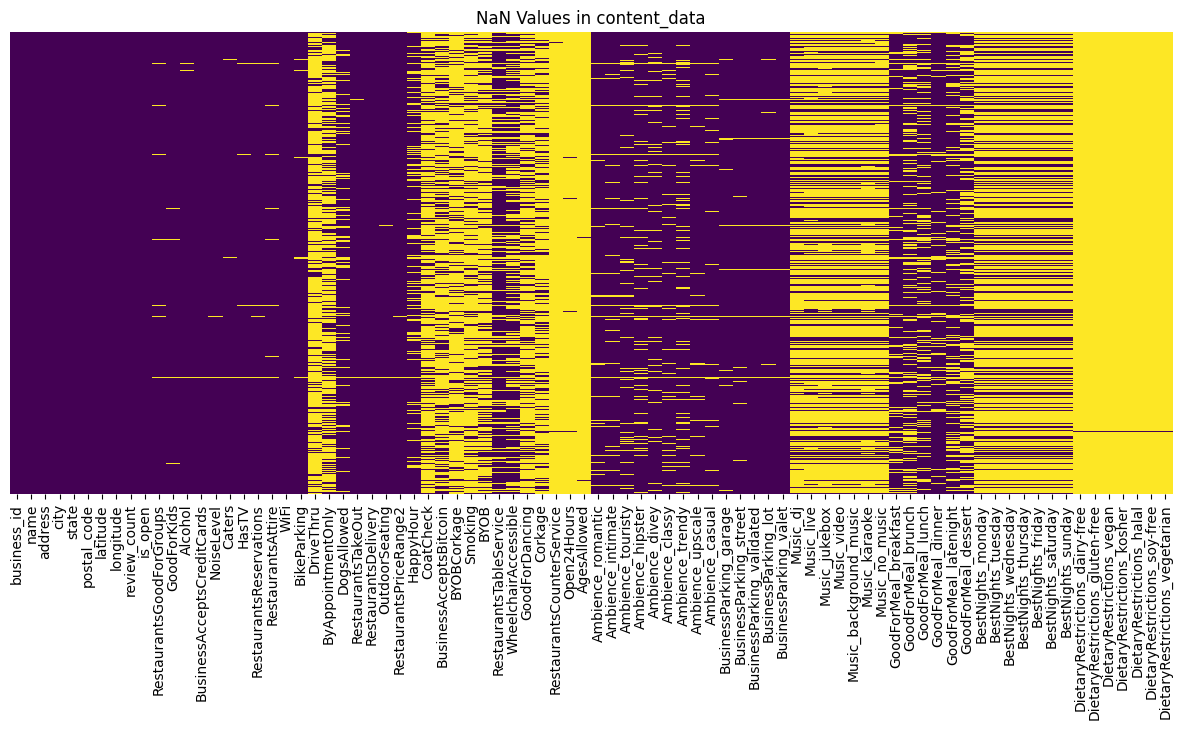

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

nan_mask = content_data.isna()

# Adjust the figure size to make it wider
plt.figure(figsize=(15, 6))  # Set the width to 15 and height to 6 (adjust as needed)

sns.heatmap(nan_mask, cmap="viridis", cbar=False, yticklabels=False, xticklabels=True)
plt.title('NaN Values in content_data')  # Optional: Add a title
plt.show()

In [57]:
# Calculate the percentage of NaN values for each column
nan_percentage = content_data.isna().mean() * 100

# Create a new DataFrame with the column names and their NaN percentages
nan_df = pd.DataFrame({
    'Column': nan_percentage.index,
    'NaN_Percentage': nan_percentage.values
})

# Sort the DataFrame by the percentage of NaN values (optional)
nan_df = nan_df.sort_values(by='NaN_Percentage', ascending=True).reset_index(drop=True)
with pd.option_context('display.max_rows', None):
    print(nan_df)

                             Column  NaN_Percentage
0                       business_id        0.000000
1                              name        0.000000
2                           address        0.000000
3                              city        0.000000
4                             state        0.000000
5                       postal_code        0.000000
6                          latitude        0.000000
7                         longitude        0.000000
8                      review_count        0.000000
9                           is_open        0.000000
10                             WiFi        0.081699
11       BusinessAcceptsCreditCards        0.081699
12           RestaurantsPriceRange2        0.326797
13              RestaurantsDelivery        0.408497
14                   OutdoorSeating        0.490196
15               RestaurantsTakeOut        0.490196
16                       NoiseLevel        0.653595
17            BusinessParking_valet        0.735294
18        Bu

In [58]:
# nan_df = nan_df.sort_values(by='Column', ascending=True).reset_index(drop=True)
# with pd.option_context('display.max_rows', None):
#     print(nan_df)

In [59]:
# Find the columns with > 75% missing values
missing_percentage = content_data.isnull().mean() * 100
threshold = 75
columns_with_high_missing = missing_percentage[missing_percentage >= threshold].index.tolist()
print("Columns with more than", threshold, "% missing values:")
print(columns_with_high_missing)
# Dropping these columns due to high fraction of missing values
content_data = content_data.loc[:, missing_percentage < 75]

Columns with more than 75 % missing values:
['DriveThru', 'BYOBCorkage', 'Corkage', 'RestaurantsCounterService', 'Open24Hours', 'AgesAllowed', 'DietaryRestrictions_dairy-free', 'DietaryRestrictions_gluten-free', 'DietaryRestrictions_vegan', 'DietaryRestrictions_kosher', 'DietaryRestrictions_halal', 'DietaryRestrictions_soy-free', 'DietaryRestrictions_vegetarian']


In [60]:
# List of columns that should be dropped because they are irrelevant for recomm systems and also not UI-relevant
# Note: This is in nature a subjective judgement. For now, I will keep columns that are in form of XXXXX_XXX
# ordered in the % missing-values desc:
# List of columns that have the highest priority to drop
drop_col_1 = ['Smoking', 'CoatCheck', 'BYOB', 'GoodForDancing', 'ByAppointmentOnly', 'BusinessAcceptsBitcoin', 'RestaurantsTableService', 'NoiseLevel']
# List of columns that have the second highest priority to drop
drop_col_2 = ['WheelchairAccessible', 'HappyHour', 'DogsAllowed', 'BikeParking', 'RestaurantsAttire', 'HasTV', 'Caters']
# List of columns that are irrelevant to the actual content-based model, why? because they do not represent the characteristics of the restaurants, we can use them in UI case
drop_col_irr = ['name', 'address', 'city', 'state', 'postal_code','is_open']
# Dropping the columns
content_data.drop(drop_col_1, axis=1, inplace=True)
content_data.drop(drop_col_2, axis=1, inplace=True)
content_data.drop(drop_col_irr, axis=1, inplace=True)

In [61]:
content_data.head()

,business_id,latitude,longitude,review_count,RestaurantsGoodForGroups,GoodForKids,Alcohol,BusinessAcceptsCreditCards,RestaurantsReservations,WiFi,...,GoodForMeal_dinner,GoodForMeal_latenight,GoodForMeal_dessert,BestNights_monday,BestNights_tuesday,BestNights_wednesday,BestNights_thursday,BestNights_friday,BestNights_saturday,BestNights_sunday
0,oaboaRBUgGjbo2kfUIKDLQ,36.162649,-86.775973,593,True,True,u'none',True,False,'free',...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,SZU9c8V2GuREDN5KgyHFJw,34.408715,-119.685019,2404,False,True,'beer_and_wine',True,False,u'no',...,True,False,False,False,False,False,False,False,True,False
2,ORL4JE6tz3rJxVqkdKfegA,36.211592,-86.694319,1639,True,True,'full_bar',True,True,u'paid',...,True,True,False,False,False,False,False,True,True,True
3,dChRGpit9fM_kZK5pafNyA,39.950656,-75.170899,618,True,False,u'full_bar',True,True,'no',...,True,None,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,j9Kaj_6tSeXmVMYCgZithg,28.188219,-82.347274,496,True,True,u'full_bar',True,True,'free',...,True,None,True,False,False,True,False,True,True,False


In [69]:
# content_data.columns

In [68]:
# # Get unique values for each column
# unique_values = {col: content_data[col].unique() for col in content_data.columns}

# # Display unique values
# for col, values in unique_values.items():
#     print(f"Column '{col}' unique values: {values}")

In [65]:
# Data cleaning

# Define a function to clean up the values with ''
def clean_values(value):
    if isinstance(value, str):
        return re.sub(r"^u?'(.*?)'$", r"\1", value)
    return value  

# Apply the function to the relevant columns
content_data['Alcohol'] = content_data['Alcohol'].apply(clean_values)
content_data['WiFi'] = content_data['WiFi'].apply(clean_values)
# If there is more, let me know.S

In [67]:
# # Let's write to disk
# content_data.to_csv('data/interim_output.csv', index=False)